## Identify customer segments for online retail with the use of K-means clustering


In [6]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")  # ignore all warnings


In [8]:
df = pd.read_csv(r'H:\Machine Learing\k-means clustring\Online Retail.csv')

In [9]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [10]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [11]:
# Checking the percentage of missing values
round(100*(df.isnull().sum()/len(df.index)), 2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [12]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

# Extract useful date parts
df['InvoiceYear'] = df['InvoiceDate'].dt.year
df['InvoiceMonth'] = df['InvoiceDate'].dt.month
df['InvoiceDayOfWeek'] = df['InvoiceDate'].dt.dayofweek  # Monday=0, Sunday=6
df['IsWeekend'] = df['InvoiceDayOfWeek'].isin([5, 6]).astype(int)

# (Optional) If you want recency features
first_date = df['InvoiceDate'].min()
df['DaysSinceFirstPurchase'] = (df['InvoiceDate'] - first_date).dt.days

# Customer-level recency (if CustomerID available)
if 'CustomerID' in df.columns:
    last_purchase = df.groupby('CustomerID')['InvoiceDate'].transform('max')
    df['DaysSinceLastPurchase'] = (last_purchase - df['InvoiceDate']).dt.days


In [13]:
# Drop rows with missing CustomerID
if 'CustomerID' in df.columns:
    missing_customers = df['CustomerID'].isnull().sum()
    print(f"Dropping {missing_customers} rows with missing CustomerID")
    df= df.dropna(subset=['CustomerID'])

Dropping 135080 rows with missing CustomerID


In [14]:
# Checking the percentage of missing values
round(100*(df.isnull().sum()/len(df.index)), 2)

InvoiceNo                 0.0
StockCode                 0.0
Description               0.0
Quantity                  0.0
InvoiceDate               0.0
UnitPrice                 0.0
CustomerID                0.0
Country                   0.0
InvoiceYear               0.0
InvoiceMonth              0.0
InvoiceDayOfWeek          0.0
IsWeekend                 0.0
DaysSinceFirstPurchase    0.0
DaysSinceLastPurchase     0.0
dtype: float64

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   InvoiceNo               406829 non-null  object        
 1   StockCode               406829 non-null  object        
 2   Description             406829 non-null  object        
 3   Quantity                406829 non-null  int64         
 4   InvoiceDate             406829 non-null  datetime64[ns]
 5   UnitPrice               406829 non-null  float64       
 6   CustomerID              406829 non-null  float64       
 7   Country                 406829 non-null  object        
 8   InvoiceYear             406829 non-null  int32         
 9   InvoiceMonth            406829 non-null  int32         
 10  InvoiceDayOfWeek        406829 non-null  int32         
 11  IsWeekend               406829 non-null  int32         
 12  DaysSinceFirstPurchase  406829 non-

In [16]:
# Count duplicate rows in whole DataFrame
df.duplicated().sum()


5225

In [17]:
# Check duplicates only on CustomerID
df.duplicated(subset=['CustomerID']).sum()

# Check duplicates on multiple columns (e.g., InvoiceNo + StockCode)
df.duplicated(subset=['InvoiceNo', 'StockCode']).sum()


10148

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   InvoiceNo               406829 non-null  object        
 1   StockCode               406829 non-null  object        
 2   Description             406829 non-null  object        
 3   Quantity                406829 non-null  int64         
 4   InvoiceDate             406829 non-null  datetime64[ns]
 5   UnitPrice               406829 non-null  float64       
 6   CustomerID              406829 non-null  float64       
 7   Country                 406829 non-null  object        
 8   InvoiceYear             406829 non-null  int32         
 9   InvoiceMonth            406829 non-null  int32         
 10  InvoiceDayOfWeek        406829 non-null  int32         
 11  IsWeekend               406829 non-null  int32         
 12  DaysSinceFirstPurchase  406829 non-

In [19]:
remaining_dup_count = df.duplicated(subset= df , keep=False).sum()
print("Remaining rows part of any duplicate group (should be 0):", remaining_dup_count)


Remaining rows part of any duplicate group (should be 0): 10062


In [20]:
before = len(df)
df.drop_duplicates(subset=['InvoiceNo', 'StockCode'], inplace=True)
after = len(df)
print("Dropped", before - after, "duplicate rows")


Dropped 10148 duplicate rows


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 396681 entries, 0 to 541908
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   InvoiceNo               396681 non-null  object        
 1   StockCode               396681 non-null  object        
 2   Description             396681 non-null  object        
 3   Quantity                396681 non-null  int64         
 4   InvoiceDate             396681 non-null  datetime64[ns]
 5   UnitPrice               396681 non-null  float64       
 6   CustomerID              396681 non-null  float64       
 7   Country                 396681 non-null  object        
 8   InvoiceYear             396681 non-null  int32         
 9   InvoiceMonth            396681 non-null  int32         
 10  InvoiceDayOfWeek        396681 non-null  int32         
 11  IsWeekend               396681 non-null  int32         
 12  DaysSinceFirstPurchase  396681 non-

In [22]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYear,InvoiceMonth,InvoiceDayOfWeek,IsWeekend,DaysSinceFirstPurchase,DaysSinceLastPurchase
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010,12,2,0,0,71.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,2,0,0,71.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010,12,2,0,0,71.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,2,0,0,71.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,2,0,0,71.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,2011,12,4,0,373,0.0
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011,12,4,0,373,0.0
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011,12,4,0,373,0.0
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2011,12,4,0,373,0.0


In [23]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Select numeric columns
numeric_cols = ['Quantity', 'UnitPrice', 'TotalPrice', 'CustomerID_freq', 'StockCode_freq']
numeric_cols = [c for c in numeric_cols if c in df.columns]  # keep only existing

# --- Standardization ---
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])



print("Scaled numeric columns head:")
print(df[numeric_cols].head())

# Check mean and std after standardization
print("Means (should be ~0):")
print(df[numeric_cols].mean())
print("Std devs (should be ~1):")
print(df[numeric_cols].std())


Scaled numeric columns head:
   Quantity  UnitPrice
0 -0.024932  -0.012968
1 -0.024932  -0.000925
2 -0.016990  -0.010101
3 -0.024932  -0.000925
4 -0.024932  -0.000925
Means (should be ~0):
Quantity     1.065776e-18
UnitPrice   -4.728819e-18
dtype: float64
Std devs (should be ~1):
Quantity     1.000001
UnitPrice    1.000001
dtype: float64


In [24]:
# Select numeric columns you want to scale
numeric_cols = ['Quantity', 'UnitPrice', 'TotalPrice', 'CustomerID_freq', 'StockCode_freq']
numeric_cols = [c for c in numeric_cols if c in df.columns]

# --- Normalization (Min-Max scaling 0–1) ---
scaler = MinMaxScaler()
df_norm = df.copy()
df_norm[numeric_cols] = scaler.fit_transform(df_norm[numeric_cols])

# Show head
print("Normalized numeric columns head:")
print(df_norm[numeric_cols].head())

# Check min and max
print("\nMin values (should be 0):")
print(df_norm[numeric_cols].min())

print("\nMax values (should be 1):")
print(df_norm[numeric_cols].max())


Normalized numeric columns head:
   Quantity  UnitPrice
0  0.500037   0.000065
1  0.500037   0.000087
2  0.500049   0.000071
3  0.500037   0.000087
4  0.500037   0.000087

Min values (should be 0):
Quantity     0.0
UnitPrice    0.0
dtype: float64

Max values (should be 1):
Quantity     1.0
UnitPrice    1.0
dtype: float64


In [25]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

country_encoded = ohe.fit_transform(df[['Country']])
country_cols = ohe.get_feature_names_out(['Country'])

df_country = pd.DataFrame(country_encoded, columns=country_cols, index=df.index)
df = pd.concat([df, df_country], axis=1)

print("OHE columns:", country_cols[:10])
print(df[country_cols].head())


OHE columns: ['Country_Australia' 'Country_Austria' 'Country_Bahrain' 'Country_Belgium'
 'Country_Brazil' 'Country_Canada' 'Country_Channel Islands'
 'Country_Cyprus' 'Country_Czech Republic' 'Country_Denmark']
   Country_Australia  Country_Austria  Country_Bahrain  Country_Belgium  \
0                0.0              0.0              0.0              0.0   
1                0.0              0.0              0.0              0.0   
2                0.0              0.0              0.0              0.0   
3                0.0              0.0              0.0              0.0   
4                0.0              0.0              0.0              0.0   

   Country_Brazil  Country_Canada  Country_Channel Islands  Country_Cyprus  \
0             0.0             0.0                      0.0             0.0   
1             0.0             0.0                      0.0             0.0   
2             0.0             0.0                      0.0             0.0   
3             0.0         

In [26]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYear,InvoiceMonth,...,Country_RSA,Country_Saudi Arabia,Country_Singapore,Country_Spain,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,-0.024932,2010-12-01 08:26:00,-0.012968,17850.0,United Kingdom,2010,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,536365,71053,WHITE METAL LANTERN,-0.024932,2010-12-01 08:26:00,-0.000925,17850.0,United Kingdom,2010,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,-0.016990,2010-12-01 08:26:00,-0.010101,17850.0,United Kingdom,2010,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,-0.024932,2010-12-01 08:26:00,-0.000925,17850.0,United Kingdom,2010,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,-0.024932,2010-12-01 08:26:00,-0.000925,17850.0,United Kingdom,2010,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,-0.001105,2011-12-09 12:50:00,-0.037340,12680.0,France,2011,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,-0.024932,2011-12-09 12:50:00,-0.019419,12680.0,France,2011,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,-0.032874,2011-12-09 12:50:00,0.009970,12680.0,France,2011,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,-0.032874,2011-12-09 12:50:00,0.009970,12680.0,France,2011,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
if 'InvoiceDate' in df.columns:
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
else:
    raise KeyError("InvoiceDate column missing")

In [28]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYear,InvoiceMonth,...,Country_RSA,Country_Saudi Arabia,Country_Singapore,Country_Spain,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,-0.024932,2010-12-01 08:26:00,-0.012968,17850.0,United Kingdom,2010,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,536365,71053,WHITE METAL LANTERN,-0.024932,2010-12-01 08:26:00,-0.000925,17850.0,United Kingdom,2010,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,-0.016990,2010-12-01 08:26:00,-0.010101,17850.0,United Kingdom,2010,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,-0.024932,2010-12-01 08:26:00,-0.000925,17850.0,United Kingdom,2010,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,-0.024932,2010-12-01 08:26:00,-0.000925,17850.0,United Kingdom,2010,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,-0.001105,2011-12-09 12:50:00,-0.037340,12680.0,France,2011,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,-0.024932,2011-12-09 12:50:00,-0.019419,12680.0,France,2011,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,-0.032874,2011-12-09 12:50:00,0.009970,12680.0,France,2011,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,-0.032874,2011-12-09 12:50:00,0.009970,12680.0,France,2011,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
df = df.assign(TotalPrice = df['Quantity'] * df['UnitPrice'])

In [30]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYear,InvoiceMonth,...,Country_Saudi Arabia,Country_Singapore,Country_Spain,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,-0.024932,2010-12-01 08:26:00,-0.012968,17850.0,United Kingdom,2010,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000323
1,536365,71053,WHITE METAL LANTERN,-0.024932,2010-12-01 08:26:00,-0.000925,17850.0,United Kingdom,2010,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000023
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,-0.016990,2010-12-01 08:26:00,-0.010101,17850.0,United Kingdom,2010,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000172
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,-0.024932,2010-12-01 08:26:00,-0.000925,17850.0,United Kingdom,2010,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000023
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,-0.024932,2010-12-01 08:26:00,-0.000925,17850.0,United Kingdom,2010,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,-0.001105,2011-12-09 12:50:00,-0.037340,12680.0,France,2011,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000041
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,-0.024932,2011-12-09 12:50:00,-0.019419,12680.0,France,2011,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000484
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,-0.032874,2011-12-09 12:50:00,0.009970,12680.0,France,2011,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000328
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,-0.032874,2011-12-09 12:50:00,0.009970,12680.0,France,2011,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000328


In [31]:

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

# simple date features
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek   # Monday=0 ... Sunday=6
df['IsWeekend'] = df['DayOfWeek'].isin([5,6]).astype(int)

# verify
print("Date features sample:")
print(df[['InvoiceDate','Year','Month','DayOfWeek','IsWeekend']].head(3).to_string(index=False))


Date features sample:
        InvoiceDate  Year  Month  DayOfWeek  IsWeekend
2010-12-01 08:26:00  2010     12          2          0
2010-12-01 08:26:00  2010     12          2          0
2010-12-01 08:26:00  2010     12          2          0


In [32]:

df['CustomerID_filled'] = df['CustomerID'].fillna(0)


cust_invoice_count = df.groupby('CustomerID_filled')['InvoiceNo'].nunique()
df['CustomerInvoiceCount'] = df['CustomerID_filled'].map(cust_invoice_count)


cust_total_spend = df.groupby('CustomerID_filled')['TotalPrice'].sum()
df['CustomerTotalSpend'] = df['CustomerID_filled'].map(cust_total_spend)

# verify sample
print("Customer aggregates sample:")
print(df[['CustomerID_filled','CustomerInvoiceCount','CustomerTotalSpend']].drop_duplicates().head(5).to_string(index=False))


Customer aggregates sample:
 CustomerID_filled  CustomerInvoiceCount  CustomerTotalSpend
           17850.0                    35           -0.129929
           13047.0                    18           -0.175920
           12583.0                    18           -0.522949
           13748.0                     5           -0.042960
           15100.0                     6           -0.006687


In [33]:
# reference date = dataset 
ref_date = df['InvoiceDate'].max()
print("Reference date:", ref_date)

# Recency = ref_date - last purchase date of customer (in days)
last_purchase = df.groupby('CustomerID_filled')['InvoiceDate'].max()
recency_days = (ref_date - last_purchase).dt.days
# Frequency and Monetary reused from above
frequency = cust_invoice_count
monetary = cust_total_spend

# create a customer-level dataframe rfm
rfm = pd.DataFrame({
    'Recency_days': recency_days,
    'Frequency': frequency,
    'Monetary': monetary
}).reset_index()

print("RFM sample (top 5 customers):")
print(rfm.head(5).to_string(index=False))


Reference date: 2011-12-09 12:50:00
RFM sample (top 5 customers):
 CustomerID_filled  Recency_days  Frequency  Monetary
           12346.0           325          2  0.003376
           12347.0             1          7 -0.134927
           12348.0            74          4 -0.333711
           12349.0            18          1 -0.270736
           12350.0           309          1 -0.024301


In [37]:
 ## out_path = r"H:\Machine Learing\k-means clustring\retail_processed.csv"
 ## df.to_csv(out_path, index=False)
 ## print("Saved to:", out_path)


In [42]:
# === Cell 5A: Transaction-level features (TotalPrice, date parts, return flags) ===
import pandas as pd
import numpy as np

if 'df' not in globals():
    raise RuntimeError("DataFrame 'df' not found. Run Load/Clean/Transform steps first.")

# 1) TotalPrice (create only if absent)
if 'TotalPrice' not in df.columns:
    if {'Quantity','UnitPrice'}.issubset(df.columns):
        df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
        print("Created 'TotalPrice'.")
    else:
        raise KeyError("Quantity and/or UnitPrice missing; can't create TotalPrice.")

# 2) Date parts (InvoiceDate must exist or be created earlier)
if 'InvoiceDate' in df.columns:
    if not pd.api.types.is_datetime64_any_dtype(df['InvoiceDate']):
        df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
    df['InvoiceYear']      = df['InvoiceDate'].dt.year
    df['InvoiceMonth']     = df['InvoiceDate'].dt.month
    df['InvoiceDayOfWeek'] = df['InvoiceDate'].dt.dayofweek
    df['IsWeekend']        = df['InvoiceDayOfWeek'].isin([5,6]).astype(int)
    print("Created date parts.")
else:
    print("Warning: 'InvoiceDate' not in df; skipping date parts.")

# 3) Return flags (non-destructive)
if 'Quantity' in df.columns and 'IsReturn_qty' not in df.columns:
    df['IsReturn_qty'] = (df['Quantity'] < 0).astype(int)
    print("Created 'IsReturn_qty' flag.")
if 'InvoiceNo' in df.columns and 'IsReturn_invoice' not in df.columns:
    df['IsReturn_invoice'] = df['InvoiceNo'].astype(str).str.startswith('C').astype(int)
    print("Created 'IsReturn_invoice' flag.")

# quick preview (transaction-level)
preview_cols = [c for c in ['Quantity','UnitPrice','TotalPrice','InvoiceDate','InvoiceMonth','IsWeekend','IsReturn_qty','IsReturn_invoice'] if c in df.columns]
print("Previewing transaction-level engineered features:")
display(df[preview_cols].head(5))


Created date parts.
Created 'IsReturn_qty' flag.
Created 'IsReturn_invoice' flag.
Previewing transaction-level engineered features:


,Quantity,UnitPrice,TotalPrice,InvoiceDate,InvoiceMonth,IsWeekend,IsReturn_qty,IsReturn_invoice
0,-0.024932,-0.012968,0.000323,2010-12-01 08:26:00,12,0,1,0
1,-0.024932,-0.000925,0.000023,2010-12-01 08:26:00,12,0,1,0
2,-0.016990,-0.010101,0.000172,2010-12-01 08:26:00,12,0,1,0
3,-0.024932,-0.000925,0.000023,2010-12-01 08:26:00,12,0,1,0
4,-0.024932,-0.000925,0.000023,2010-12-01 08:26:00,12,0,1,0


In [44]:
# === Cell 5B: Customer-level aggregation (RFM-style) ===
import numpy as np

# Choose customer id column (prefer CustomerID if present, else CustomerID_filled)
if 'CustomerID' in df.columns:
    cust_key = 'CustomerID'
elif 'CustomerID_filled' in df.columns:
    cust_key = 'CustomerID_filled'
else:
    raise KeyError("No CustomerID or CustomerID_filled column found. Fill customer IDs and re-run Step 5B.")

# Aggregation: one row per customer
df_cust = df.groupby(cust_key).agg(
    CustomerInvoiceCount  = ('InvoiceNo','nunique'),
    CustomerTotalSpend    = ('TotalPrice','sum'),
    CustomerNumItems      = ('Quantity','sum'),
    CustomerAvgOrderValue = ('TotalPrice','mean'),
    FirstPurchase         = ('InvoiceDate','min'),
    LastPurchase          = ('InvoiceDate','max')
).reset_index()

# Recency relative to dataset max date
if 'InvoiceDate' in df.columns:
    ref_date = df['InvoiceDate'].max()
    df_cust['Recency_days'] = (ref_date - df_cust['LastPurchase']).dt.days
else:
    df_cust['Recency_days'] = np.nan

print("Customer-level table created: rows =", len(df_cust))
display(df_cust.head(5))


Customer-level table created: rows = 4372


,CustomerID,CustomerInvoiceCount,CustomerTotalSpend,CustomerNumItems,CustomerAvgOrderValue,FirstPurchase,LastPurchase,Recency_days
0,12346.0,2,0.003376,-0.097516,0.001688,2011-01-18 10:01:00,2011-01-18 10:17:00,325
1,12347.0,7,-0.134927,0.886941,-0.000741,2010-12-07 14:57:00,2011-12-07 15:52:00,1
2,12348.0,4,-0.333711,6.073725,-0.012360,2010-12-16 19:09:00,2011-09-25 13:13:00,74
3,12349.0,1,-0.270736,-1.053593,-0.003709,2011-11-21 09:51:00,2011-11-21 09:51:00,18
4,12350.0,1,-0.024301,-0.046585,-0.001429,2011-02-02 16:01:00,2011-02-02 16:01:00,309


In [46]:
# === Cell 5C: Log-transform skewed features and prepare candidate_features ===
import numpy as np

# Work on a copy so original df_cust remains available
cust_proc = df_cust.copy()

# Create log versions only if source columns exist
log_sources = ['CustomerTotalSpend','CustomerNumItems','CustomerAvgOrderValue']
created_logs = []
for col in log_sources:
    if col in cust_proc.columns:
        ln = col + '_log'
        if ln not in cust_proc.columns:
            cust_proc[ln] = np.log1p(cust_proc[col].fillna(0))
            created_logs.append(ln)
            print(f"Created {ln}")
        else:
            created_logs.append(ln)
            print(f"{ln} already exists")
    else:
        print(f"Source column {col} not found; skipping log transform for it.")

# Candidate features (only include those that exist)
candidate_features = []
for c in ['Recency_days','CustomerInvoiceCount'] + created_logs:
    if c in cust_proc.columns:
        candidate_features.append(c)

if not candidate_features:
    raise ValueError("No candidate features found. Ensure df_cust has Recency/CustomerTotalSpend/CustomerInvoiceCount etc.")
print("Candidate features:", candidate_features)
display(cust_proc[candidate_features].describe().T)


Created CustomerTotalSpend_log
Created CustomerNumItems_log
Created CustomerAvgOrderValue_log
Candidate features: ['Recency_days', 'CustomerInvoiceCount', 'CustomerTotalSpend_log', 'CustomerNumItems_log', 'CustomerAvgOrderValue_log']


,count,mean,std,min,25%,50%,75%,max
Recency_days,4372.0,91.047118,100.765435,0.000000,16.000000,49.000000,142.000000,373.000000
CustomerInvoiceCount,4372.0,5.075480,9.338754,1.000000,1.000000,3.000000,5.000000,248.000000
CustomerTotalSpend_log,4317.0,-0.073898,0.258072,-7.064053,-0.071866,-0.023901,-0.004034,1.282987
CustomerNumItems_log,3081.0,0.009453,1.179964,-8.184491,-0.446436,-0.052787,0.432094,6.522869
CustomerAvgOrderValue_log,4367.0,-0.003255,0.037948,-1.887732,-0.001418,-0.000745,-0.000192,0.022236


In [48]:
# === Cell 5D: Feature selection (RandomForest importances + SelectKBest) ===
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np

# Require CustomerTotalSpend to create supervised target
if 'CustomerTotalSpend' not in cust_proc.columns:
    raise KeyError("CustomerTotalSpend not found in customer table. Run Step 5B.")

cust_proc['is_high_value'] = (cust_proc['CustomerTotalSpend'] >= cust_proc['CustomerTotalSpend'].quantile(0.70)).astype(int)
print("Target 'is_high_value' distribution:")
print(cust_proc['is_high_value'].value_counts())

# Prepare X and y
X = cust_proc[candidate_features].fillna(0)
y = cust_proc['is_high_value']

# RandomForest feature importances (if target has >1 class)
if len(np.unique(y)) > 1 and len(candidate_features) > 0:
    rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    rf.fit(X, y)
    feat_imp = pd.Series(rf.feature_importances_, index=candidate_features).sort_values(ascending=False)
    print("RandomForest feature importances:")
    display(feat_imp)
else:
    feat_imp = pd.Series(dtype=float)
    print("Skipping RandomForest: not enough distinct classes in target or no candidate features.")

# SelectKBest (ANOVA F-test) as alternative
try:
    skb = SelectKBest(score_func=f_classif, k=min(3, X.shape[1]))
    skb.fit(X, y)
    skb_scores = pd.Series(skb.scores_, index=candidate_features).sort_values(ascending=False)
    selected_by_skb = [f for f, sel in zip(candidate_features, skb.get_support()) if sel]
    print("SelectKBest F-scores:")
    display(skb_scores)
    print("SelectKBest selected:", selected_by_skb)
except Exception as e:
    print("SelectKBest skipped due to error:", e)
    selected_by_skb = []


Target 'is_high_value' distribution:
is_high_value
0    3060
1    1312
Name: count, dtype: int64
RandomForest feature importances:


CustomerTotalSpend_log       0.654115
CustomerAvgOrderValue_log    0.284147
CustomerNumItems_log         0.040508
CustomerInvoiceCount         0.017627
Recency_days                 0.003603
dtype: float64

SelectKBest F-scores:


CustomerTotalSpend_log       308.810850
CustomerNumItems_log         103.046370
CustomerInvoiceCount          66.581773
Recency_days                  61.395141
CustomerAvgOrderValue_log     14.956751
dtype: float64

SelectKBest selected: ['CustomerInvoiceCount', 'CustomerTotalSpend_log', 'CustomerNumItems_log']


In [50]:

final_features = []
if 'feat_imp' in globals() and not feat_imp.empty:
    k_pick = min(3, len(feat_imp))
    final_features = feat_imp.head(k_pick).index.tolist()
    print("Final features chosen from RF:", final_features)
elif 'selected_by_skb' in globals() and selected_by_skb:
    final_features = selected_by_skb
    print("Final features chosen from SelectKBest:", final_features)
else:
    final_features = candidate_features[:3]
    print("Fallback final features selected:", final_features)

# Quick verification: show distribution and sample
print("\nFinal features list:", final_features)
display(cust_proc[final_features].head(6))

print("\nSanity checks:")
print(" - Any NaNs in final features?", cust_proc[final_features].isnull().any().to_dict())
print(" - Customer rows in cust_proc:", len(cust_proc))


Final features chosen from RF: ['CustomerTotalSpend_log', 'CustomerAvgOrderValue_log', 'CustomerNumItems_log']

Final features list: ['CustomerTotalSpend_log', 'CustomerAvgOrderValue_log', 'CustomerNumItems_log']


,CustomerTotalSpend_log,CustomerAvgOrderValue_log,CustomerNumItems_log
0,0.003370,0.001686,-0.102605
1,-0.144942,-0.000742,0.634957
2,-0.406032,-0.012437,1.956387
3,-0.315719,-0.003716,NaN
4,-0.024601,-0.001430,-0.047705
5,-2.216289,-0.009732,NaN



Sanity checks:
 - Any NaNs in final features? {'CustomerTotalSpend_log': True, 'CustomerAvgOrderValue_log': True, 'CustomerNumItems_log': True}
 - Customer rows in cust_proc: 4372


In [52]:
# === 1. Standardize the Data ===
from sklearn.preprocessing import StandardScaler

# Use customer-level dataset (df_cust or cust_proc depending on what you have)
X = cust_proc[final_features].fillna(0)

# Standardize (mean=0, std=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Shape of standardized data:", X_scaled.shape)
print("Means (≈0):", X_scaled.mean(axis=0))
print("Std devs (≈1):", X_scaled.std(axis=0))


Shape of standardized data: (4372, 3)
Means (≈0): [ 9.75127268e-18  1.13764848e-17 -1.09701818e-17]
Std devs (≈1): [1. 1. 1.]


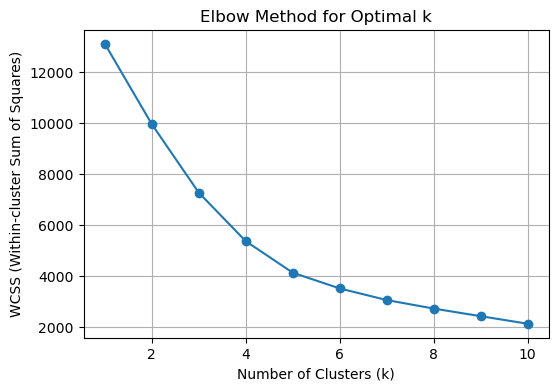

In [54]:
# === 2. Determine optimal k with Elbow Method ===
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(6,4))
plt.plot(K_range, wcss, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS (Within-cluster Sum of Squares)")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.show()


In [56]:
# === 3. Run K-Means Clustering ===
optimal_k = 4   # 👈 change this to the value you decide from elbow plot

kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
cust_proc['Cluster'] = kmeans.fit_predict(X_scaled)

print("Cluster labels assigned. Example distribution:")
print(cust_proc['Cluster'].value_counts())

# Preview cluster assignments
display(cust_proc[['CustomerID'] + final_features + ['Cluster']].head(10))


Cluster labels assigned. Example distribution:
Cluster
0    3845
3     498
2      27
1       2
Name: count, dtype: int64


,CustomerID,CustomerTotalSpend_log,CustomerAvgOrderValue_log,CustomerNumItems_log,Cluster
0,12346.0,0.003370,0.001686,-0.102605,0
1,12347.0,-0.144942,-0.000742,0.634957,0
2,12348.0,-0.406032,-0.012437,1.956387,3
3,12349.0,-0.315719,-0.003716,NaN,0
4,12350.0,-0.024601,-0.001430,-0.047705,0
5,12352.0,-2.216289,-0.009732,NaN,2
6,12353.0,-0.006213,-0.001550,-0.122858,0
7,12354.0,-0.089185,-0.001472,-1.284820,0
8,12355.0,-0.028251,-0.002145,0.277029,0
9,12356.0,-0.153614,-0.002416,1.490940,3


In [60]:
# Cell 1: Ensure cluster results exist and set variables (adjust names if needed)

import seaborn as sns
from sklearn.decomposition import PCA

# Names used in previous steps: cust, cust_proc, df_cust
# Pick the customer-level table that has Cluster labels
if 'cust' in globals() and 'Cluster' in cust.columns:
    customers = cust.copy()
    print("Using 'cust' as customer-level table.")
elif 'cust_proc' in globals() and 'Cluster' in cust_proc.columns:
    customers = cust_proc.copy()
    print("Using 'cust_proc' as customer-level table.")
elif 'df_cust' in globals() and 'Cluster' in df_cust.columns:
    customers = df_cust.copy()
    print("Using 'df_cust' as customer-level table.")
else:
    raise RuntimeError("No customer-level table with 'Cluster' found. Run KMeans and ensure 'Cluster' column exists in cust/cust_proc/df_cust.")

# If you want original transaction-level df with cluster labels later, we will use 'df' variable.
print("Customer rows:", len(customers))
print("Cluster value counts:\n", customers['Cluster'].value_counts())


Using 'cust_proc' as customer-level table.
Customer rows: 4372
Cluster value counts:
 Cluster
0    3845
3     498
2      27
1       2
Name: count, dtype: int64


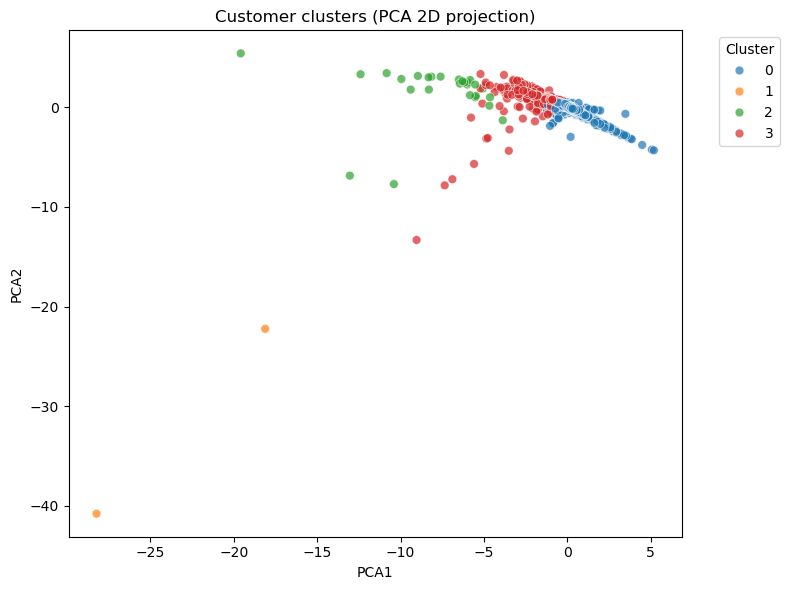

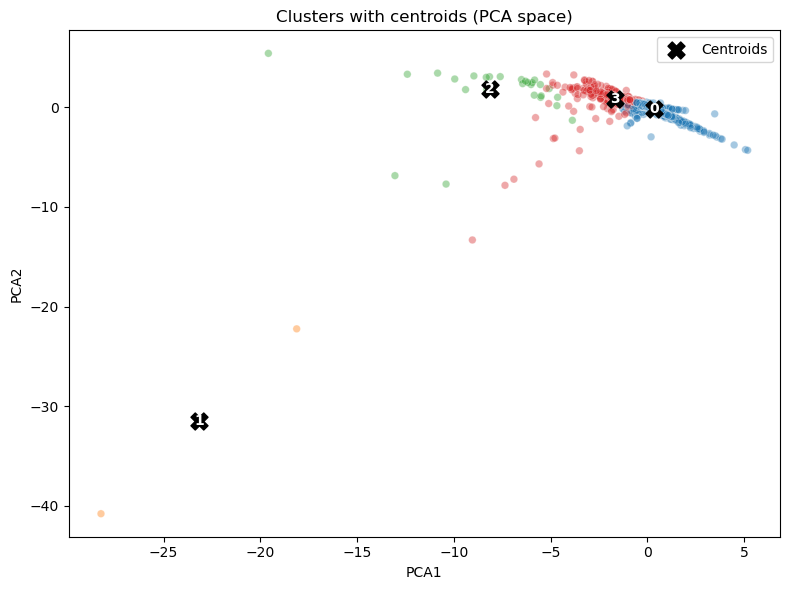

In [62]:
# Cell 2: PCA to 2D for visualization, scatter with cluster colors and centroids
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Choose numerical features used for clustering (final_features should exist)
if 'final_features' in globals() and isinstance(final_features, list) and final_features:
    features_for_viz = final_features
else:
    # fallback: choose numeric columns excluding ID and cluster
    features_for_viz = [c for c in customers.select_dtypes(include=[np.number]).columns if c not in ('Cluster',)]
    print("No final_features found; using numeric columns:", features_for_viz[:8])

X = customers[features_for_viz].fillna(0).values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

customers['_pca1'] = X_pca[:,0]
customers['_pca2'] = X_pca[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=customers, x='_pca1', y='_pca2', hue='Cluster', palette='tab10', s=40, alpha=0.7)
plt.title("Customer clusters (PCA 2D projection)")
plt.xlabel("PCA1"); plt.ylabel("PCA2")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot centroids in PCA space (centroids computed in original feature space)
centroids = customers.groupby('Cluster')[features_for_viz].mean().values
# project centroids with the same scaler and PCA:
centroids_scaled = scaler.transform(customers.groupby('Cluster')[features_for_viz].mean().values)
centroids_pca = pca.transform(centroids_scaled)
plt.figure(figsize=(8,6))
sns.scatterplot(x=customers['_pca1'], y=customers['_pca2'], hue=customers['Cluster'], palette='tab10', s=30, alpha=0.4, legend=False)
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], c='black', s=150, marker='X', label='Centroids')
for i, (x,y) in enumerate(centroids_pca):
    plt.text(x, y, str(i), color='white', weight='bold', ha='center', va='center')
plt.title("Clusters with centroids (PCA space)")
plt.xlabel("PCA1"); plt.ylabel("PCA2")
plt.legend(loc='best')
plt.tight_layout()
plt.show()
